In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import torch
from transformers import pipeline, BertTokenizer, BertForSequenceClassification
from datasets import Dataset
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
start_time = time.time()
complaints_cfpb = pd.DataFrame()

for chunk in pd.read_csv('complaints.csv', chunksize=400000):
    print('Number of rows in this chunk: ', chunk.shape)
    complaints_cfpb = pd.concat([complaints_cfpb, chunk], ignore_index=True)

print("Time taken to read the data: ", time.time() - start_time)
print("Shape of the full dataframe: ", complaints_cfpb.shape)


Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (400000, 18)
Number of rows in this chunk:  (335939, 18)
Time taken to read the data:  37.16552138328552
Shape of the full dataframe:  (6335939, 18)


In [5]:
complaints_cfpb = complaints_cfpb[complaints_cfpb['Date received'] >= '2023-01-01']
print(complaints_cfpb.shape)  

(3121960, 18)


In [6]:
complaints_cfpb.dropna(subset=['Consumer complaint narrative'], inplace=True)

In [7]:
missing_values = complaints_cfpb['Consumer complaint narrative'].isna().sum()
print(missing_values)

0


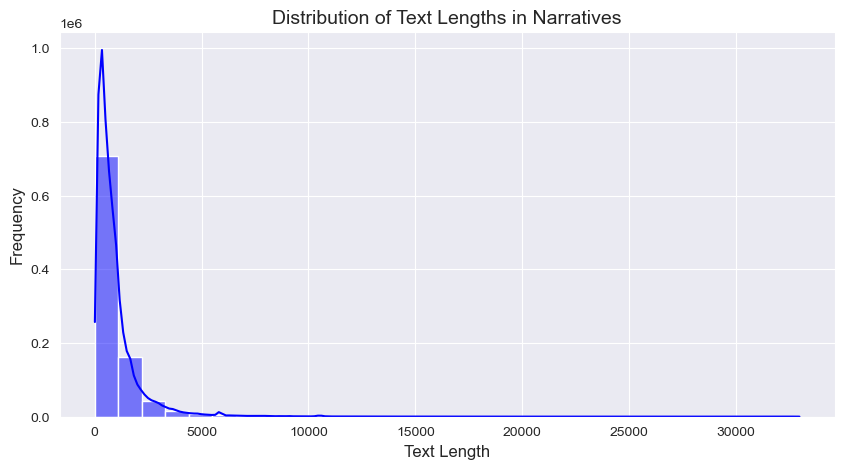

In [8]:
complaints_cfpb['Text Length'] = complaints_cfpb['Consumer complaint narrative'].dropna().apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(complaints_cfpb['Text Length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Text Lengths in Narratives', fontsize=14)
plt.xlabel('Text Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [9]:
complaints_cfpb['Consumer complaint narrative'] = complaints_cfpb['Consumer complaint narrative'].str.replace(r'\bxxxx\b', '', regex=True).str.strip()

In [10]:
complaints_cfpb.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Text Length
3,2024-06-09,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Personal information incorrect,I recently reviewed a copy of my credit report...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,91730,NaN,Consent provided,Web,2024-06-09,Closed with non-monetary relief,Yes,NaN,9213312,365
4,2024-07-24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account information incorrect,"To Whom It May Concern, I am writing in respon...",NaN,TrueAccord Corp.,TX,761XX,NaN,Consent provided,Web,2024-07-24,Closed with explanation,Yes,NaN,9592293,3856
10,2024-07-21,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX, XXXX, AZ X...",NaN,LEXISNEXIS,AZ,85297,Servicemember,Consent provided,Web,2024-07-21,Closed with explanation,Yes,NaN,9574168,3893
11,2024-07-21,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX, XXXX, AZ X...",NaN,LEXISNEXIS,AZ,85297,Servicemember,Consent provided,Web,2024-07-21,Closed with explanation,Yes,NaN,9574171,3868
12,2024-07-21,Debt collection,Rental debt,Written notification about debt,Didn't receive notice of right to dispute,"XXXX XXXX, XXXXXX/XX/XXXX XXXX XXXX, Re : Disp...",NaN,NCB Management Services Inc.,TX,77014,NaN,Consent provided,Web,2024-07-21,Closed with explanation,Yes,NaN,9568540,1636


In [11]:
stop_words = set(stopwords.words('english'))

In [12]:
word_counts = Counter()

In [13]:
for narrative in complaints_cfpb['Consumer complaint narrative'].dropna():
    try:
        words = [word.lower() for word in word_tokenize(narrative) if word.isalnum() and word.lower() not in stop_words]
        word_counts.update(words)
    except Exception as e:
        print(f"Error processing narrative: {narrative}\nError: {e}")

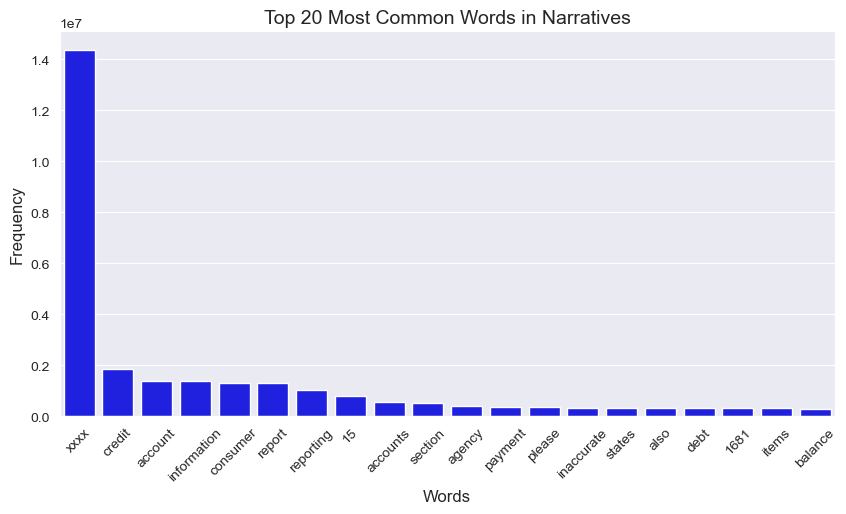

In [14]:
if len(word_counts) == 0:
    print("No words were counted. Please check the preprocessing steps.")
else:
    common_words = word_counts.most_common(20)
    words, counts = zip(*common_words)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(words), y=list(counts), color='blue')
    plt.title('Top 20 Most Common Words in Narratives', fontsize=14)
    plt.xlabel('Words', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

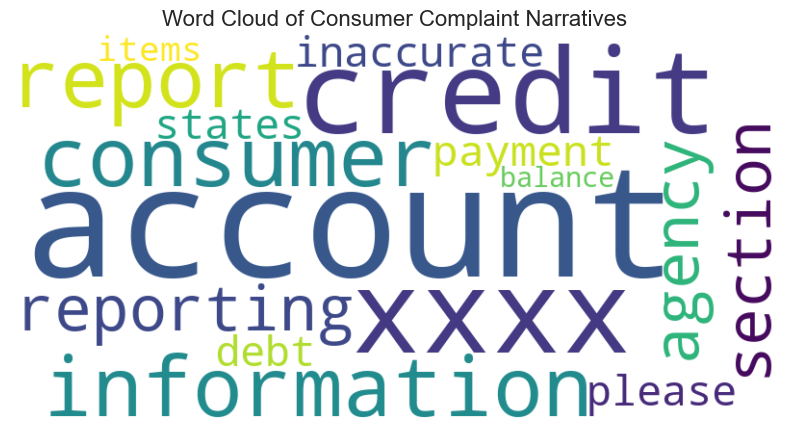

In [15]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Consumer Complaint Narratives', fontsize=16)
plt.show()


In [16]:
complaints_cfpb['Consumer complaint narrative'] = complaints_cfpb['Consumer complaint narrative'].str.replace(r'(x\s*)+', '', regex=True).str.strip()
print(complaints_cfpb.head())

   Date received                                            Product  \
3     2024-06-09  Credit reporting or other personal consumer re...   
4     2024-07-24  Credit reporting or other personal consumer re...   
10    2024-07-21  Credit reporting or other personal consumer re...   
11    2024-07-21  Credit reporting or other personal consumer re...   
12    2024-07-21                                    Debt collection   

         Sub-product                                 Issue  \
3   Credit reporting  Incorrect information on your report   
4   Credit reporting  Incorrect information on your report   
10  Credit reporting  Incorrect information on your report   
11  Credit reporting  Incorrect information on your report   
12       Rental debt       Written notification about debt   

                                    Sub-issue  \
3              Personal information incorrect   
4               Account information incorrect   
10        Information belongs to someone else   
11  

In [17]:
complaints_cfpb['Consumer complaint narrative'] = complaints_cfpb['Consumer complaint narrative'].str.replace(r'(x\s*)+', '', regex=True).str.strip()

In [18]:
complaints_cfpb = complaints_cfpb.dropna(subset=['Consumer complaint narrative'])
complaints_cfpb.head(10)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Text Length
3,2024-06-09,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Personal information incorrect,I recently reviewed a copy of my credit report...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,91730,NaN,Consent provided,Web,2024-06-09,Closed with non-monetary relief,Yes,NaN,9213312,365
4,2024-07-24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account information incorrect,"To Whom It May Concern, I am writing in respon...",NaN,TrueAccord Corp.,TX,761XX,NaN,Consent provided,Web,2024-07-24,Closed with explanation,Yes,NaN,9592293,3856
10,2024-07-21,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX, XXXX, AZ X...",NaN,LEXISNEXIS,AZ,85297,Servicemember,Consent provided,Web,2024-07-21,Closed with explanation,Yes,NaN,9574168,3893
11,2024-07-21,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX, XXXX, AZ X...",NaN,LEXISNEXIS,AZ,85297,Servicemember,Consent provided,Web,2024-07-21,Closed with explanation,Yes,NaN,9574171,3868
12,2024-07-21,Debt collection,Rental debt,Written notification about debt,Didn't receive notice of right to dispute,"XXXX XXXX, XXXXXX/XX/XXXX XXXX XXXX, Re : Disp...",NaN,NCB Management Services Inc.,TX,77014,NaN,Consent provided,Web,2024-07-21,Closed with explanation,Yes,NaN,9568540,1636
16,2024-03-06,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Was not notified of investigation status or re...,I am writing to formally lodge a complaint reg...,NaN,"EQUIFAX, INC.",SC,29485,NaN,Consent provided,Web,2024-03-06,Closed with non-monetary relief,Yes,NaN,8491259,650
20,2024-07-24,Credit card,General-purpose credit card or charge card,Struggling to pay your bill,Credit card company won't work with you while ...,I want you to know that I understand my financ...,NaN,"CLGF Holdco 1, LLC",GA,310XX,NaN,Consent provided,Web,2024-07-24,Closed with explanation,Yes,NaN,9607752,901
119,2024-07-20,Debt collection,Other debt,False statements or representation,Attempted to collect wrong amount,Syncom called my boyfriend whom I have no lega...,NaN,Synergetic Communication Inc,TN,377XX,NaN,Consent provided,Web,2024-07-20,Closed with explanation,Yes,NaN,9566142,227
192,2024-07-22,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,"Upon Checkin my Credit report, I noticed these...",Company has responded to the consumer and the ...,"Westlake Services, LLC",MI,48091,NaN,Consent provided,Web,2024-07-22,Closed with explanation,Yes,NaN,9583627,488
262,2024-08-06,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,I want to XXXX that I did not give XXXX XXXX ...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NC,28540,NaN,Consent provided,Web,2024-08-06,Closed with explanation,Yes,NaN,9719566,966


In [19]:
complaints_cfpb.shape

(951684, 19)

In [20]:
dataset = Dataset.from_pandas(complaints_cfpb[['Consumer complaint narrative']])

In [21]:
finbert_model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone").to(device)
finbert_tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")

In [22]:
finbert_pipeline = pipeline(
    "sentiment-analysis",
    model=finbert_model,
    tokenizer=finbert_tokenizer,
    device=device
)

In [23]:
def analyze_sentiment(batch):
    return {"Sentiment": [finbert_pipeline(text[:512])[0]['label'] for text in batch["Consumer complaint narrative"]]}

In [24]:
start_time = time.time()
results = dataset.map(analyze_sentiment, batched=True, batch_size=32)
print("Time taken for sentiment analysis:", time.time() - start_time)

Map:   0%|          | 0/951684 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Time taken for sentiment analysis: 6488.62299656868


In [25]:
complaints_cfpb['Sentiment'] = results['Sentiment']

In [26]:
complaints_cfpb[['Consumer complaint narrative', 'Sentiment']].head(10)

,Consumer complaint narrative,Sentiment
3,I recently reviewed a copy of my credit report...,Neutral
4,"To Whom It May Concern, I am writing in respon...",Neutral
10,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX, XXXX, AZ X...",Neutral
11,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX, XXXX, AZ X...",Neutral
12,"XXXX XXXX, XXXXXX/XX/XXXX XXXX XXXX, Re : Disp...",Neutral
16,I am writing to formally lodge a complaint reg...,Negative
20,I want you to know that I understand my financ...,Positive
119,Syncom called my boyfriend whom I have no lega...,Neutral
192,"Upon Checkin my Credit report, I noticed these...",Neutral
262,I want to XXXX that I did not give XXXX XXXX ...,Neutral


In [27]:
complaints_cfpb['Sentiment'].value_counts()

Sentiment
Neutral     733952
Negative    212383
Positive      5349
Name: count, dtype: int64

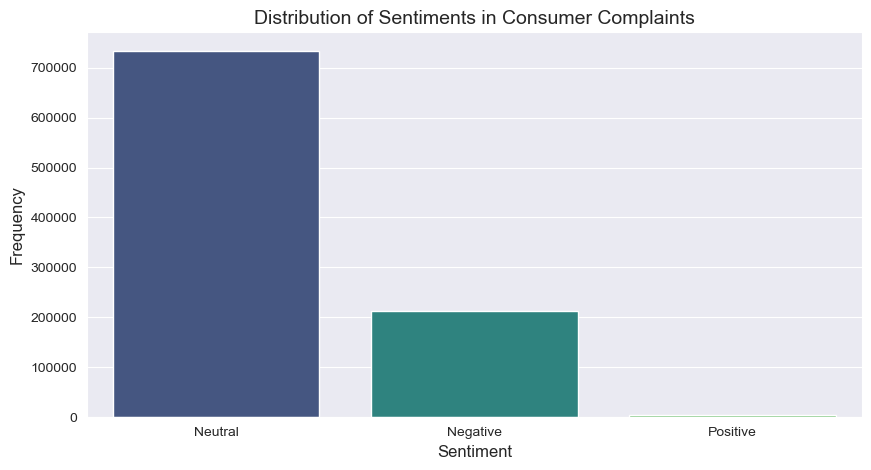

In [28]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Sentiment', data=complaints_cfpb, palette='viridis')
plt.title('Distribution of Sentiments in Consumer Complaints', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [36]:
negative_sentiments = complaints_cfpb[complaints_cfpb['Sentiment'] == 'Negative']
negative_sentiments.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Text Length,Sentiment
16,2024-03-06,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Was not notified of investigation status or re...,I am writing to formally lodge a complaint reg...,NaN,"EQUIFAX, INC.",SC,29485,NaN,Consent provided,Web,2024-03-06,Closed with non-monetary relief,Yes,NaN,8491259,650,Negative
1044,2024-08-03,Credit card,General-purpose credit card or charge card,"Advertising and marketing, including promotion...",Didn't receive advertised or promotional terms,I am writing to epress my deep dissatisfaction...,NaN,JPMORGAN CHASE & CO.,VA,23608,NaN,Consent provided,Web,2024-08-03,Closed with monetary relief,Yes,NaN,9700868,1543,Negative
1210,2024-07-24,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,"Lies, lies and lies are used by CITIBank. Afte...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,95062,Older American,Consent provided,Web,2024-07-24,Closed with non-monetary relief,Yes,NaN,9605357,1599,Negative
1681,2024-06-09,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,My account with all the companies that I inclu...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MD,20910,NaN,Consent provided,Web,2024-06-09,Closed with explanation,Yes,NaN,9207069,1275,Negative
1980,2024-08-06,Mortgage,Home equity loan or line of credit (HELOC),Trouble during payment process,Payment process,Shellpoint XXXX and its associated nightmare ...,Company believes the complaint provided an opp...,"Shellpoint Partners, LLC",CA,90033,NaN,Consent provided,Web,2024-08-06,Closed with explanation,Yes,NaN,9722682,1960,Negative


In [42]:
def generate_visuals(sentiment):
    filtered_data = complaints_cfpb[complaints_cfpb['Sentiment'] == sentiment]

    narratives = " ".join(filtered_data['Consumer complaint narrative'].dropna())

    words = [word.lower() for word in nltk.word_tokenize(narratives) if word.isalnum() and word.lower() not in stop_words]

    word_counts = Counter(words)
    common_words = word_counts.most_common(20)
    
    words, counts = zip(*common_words)
 
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(words))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Sentiment', fontsize=16)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.bar(words, counts, color='blue')
    plt.title(f'Top 20 Words for {sentiment} Sentiment', fontsize=16)
    plt.xlabel('Words', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

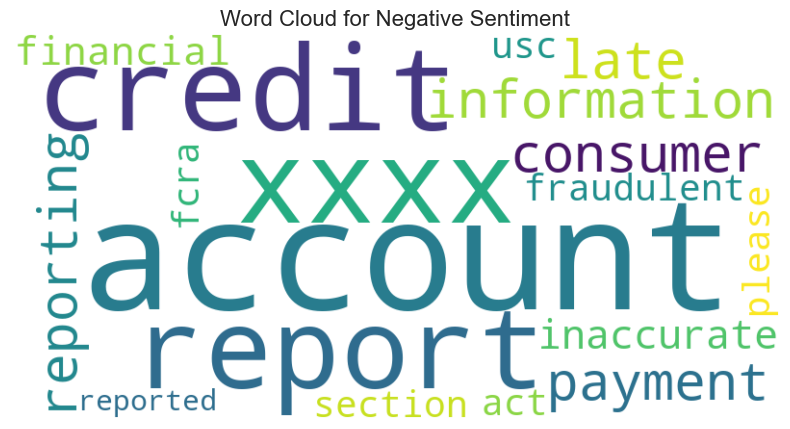

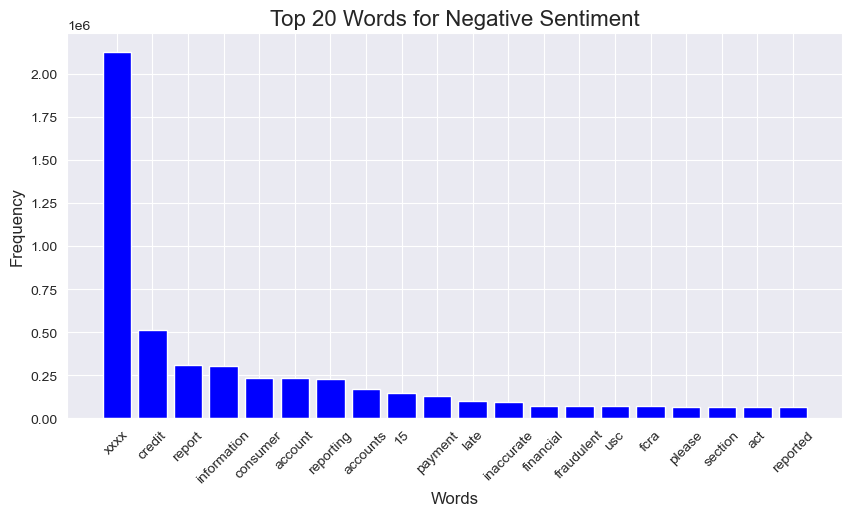

In [44]:
generate_visuals('Negative')

In [46]:
positive_sentiments = complaints_cfpb[complaints_cfpb['Sentiment'] == 'Positive']
positive_sentiments.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Text Length,Sentiment
20,2024-07-24,Credit card,General-purpose credit card or charge card,Struggling to pay your bill,Credit card company won't work with you while ...,I want you to know that I understand my financ...,NaN,"CLGF Holdco 1, LLC",GA,310XX,NaN,Consent provided,Web,2024-07-24,Closed with explanation,Yes,NaN,9607752,901,Positive
3434,2024-07-28,"Money transfer, virtual currency, or money ser...",Mobile or digital wallet,Fraud or scam,NaN,"Starting more than a year ago, I began contact...",NaN,"Paypal Holdings, Inc",CA,95354,NaN,Consent provided,Web,2024-07-28,Closed with explanation,Yes,NaN,9633810,1224,Positive
11101,2024-08-19,Checking or savings account,Savings account,Problem caused by your funds being low,Non-sufficient funds and associated fees,There is a fee on my savings account because t...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",RI,02886,NaN,Consent provided,Web,2024-08-19,Closed with monetary relief,Yes,NaN,9846687,457,Positive
11262,2024-08-06,Credit card,General-purpose credit card or charge card,Getting a credit card,Card opened without my consent or knowledge,My wife passed away in XXXX and she had handl...,NaN,DISCOVER BANK,OK,741XX,NaN,Consent provided,Web,2024-08-06,Closed with explanation,Yes,NaN,9719859,1351,Positive
11422,2024-04-18,Credit card,General-purpose credit card or charge card,Incorrect information on your report,Account status incorrect,I respectfully seek your comprehension regardi...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TN,38016,NaN,Consent provided,Web,2024-04-18,Closed with non-monetary relief,Yes,NaN,8798914,286,Positive


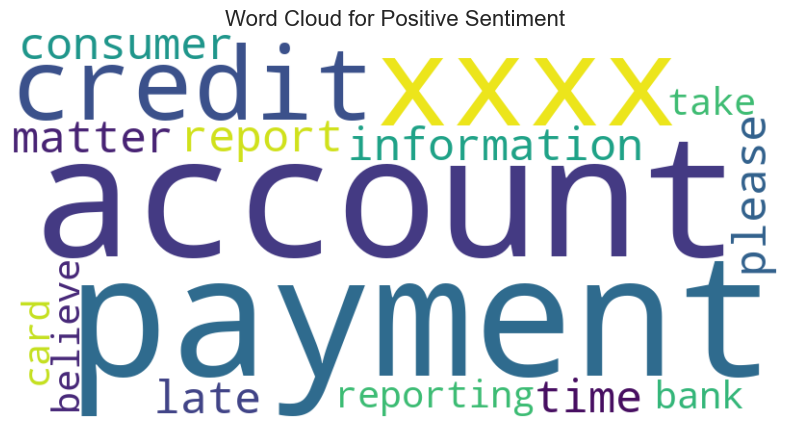

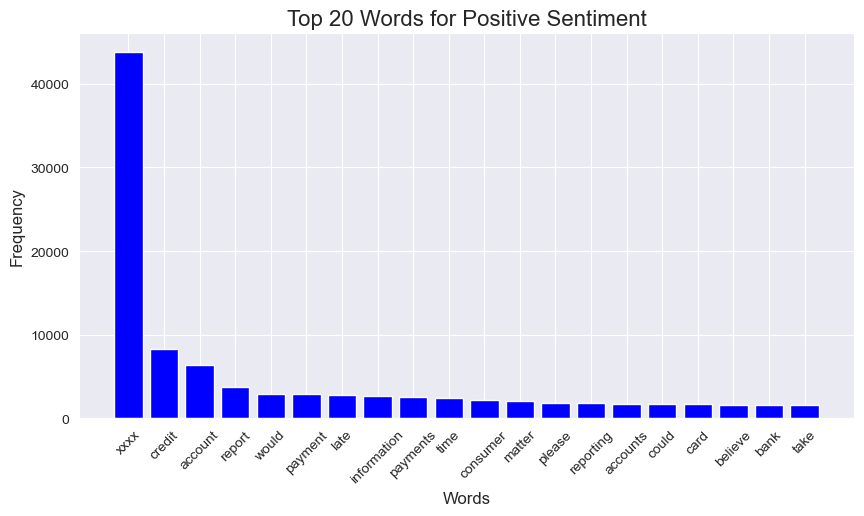

In [47]:
generate_visuals('Positive')

In [48]:
neutral_sentiments = complaints_cfpb[complaints_cfpb['Sentiment'] == 'Neutral']
neutral_sentiments.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Text Length,Sentiment
3,2024-06-09,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Personal information incorrect,I recently reviewed a copy of my credit report...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,91730,NaN,Consent provided,Web,2024-06-09,Closed with non-monetary relief,Yes,NaN,9213312,365,Neutral
4,2024-07-24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account information incorrect,"To Whom It May Concern, I am writing in respon...",NaN,TrueAccord Corp.,TX,761XX,NaN,Consent provided,Web,2024-07-24,Closed with explanation,Yes,NaN,9592293,3856,Neutral
10,2024-07-21,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX, XXXX, AZ X...",NaN,LEXISNEXIS,AZ,85297,Servicemember,Consent provided,Web,2024-07-21,Closed with explanation,Yes,NaN,9574168,3893,Neutral
11,2024-07-21,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX, XXXX, AZ X...",NaN,LEXISNEXIS,AZ,85297,Servicemember,Consent provided,Web,2024-07-21,Closed with explanation,Yes,NaN,9574171,3868,Neutral
12,2024-07-21,Debt collection,Rental debt,Written notification about debt,Didn't receive notice of right to dispute,"XXXX XXXX, XXXXXX/XX/XXXX XXXX XXXX, Re : Disp...",NaN,NCB Management Services Inc.,TX,77014,NaN,Consent provided,Web,2024-07-21,Closed with explanation,Yes,NaN,9568540,1636,Neutral


In [50]:
def generate_visuals_neutral(sentiment):
    filtered_data = complaints_cfpb[complaints_cfpb['Sentiment'] == sentiment]

    word_counts = Counter()

    for narrative in filtered_data['Consumer complaint narrative'].dropna():
        words = [word.lower() for word in nltk.word_tokenize(narrative) if word.isalnum() and word.lower() not in stop_words]
        word_counts.update(words)
 
    common_words = word_counts.most_common(20)
 
    if not common_words:
        print(f"No words found for sentiment: {sentiment}")
        return

    words, counts = zip(*common_words)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(words))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Sentiment', fontsize=16)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.bar(words, counts, color='blue')
    plt.title(f'Top 20 Words for {sentiment} Sentiment', fontsize=16)
    plt.xlabel('Words', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

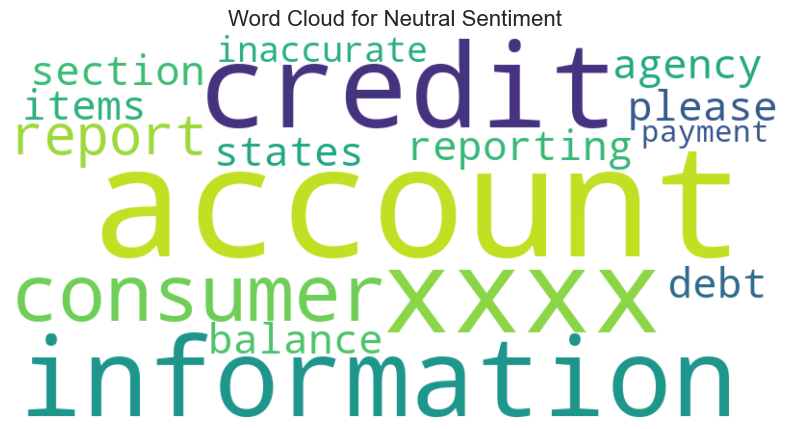

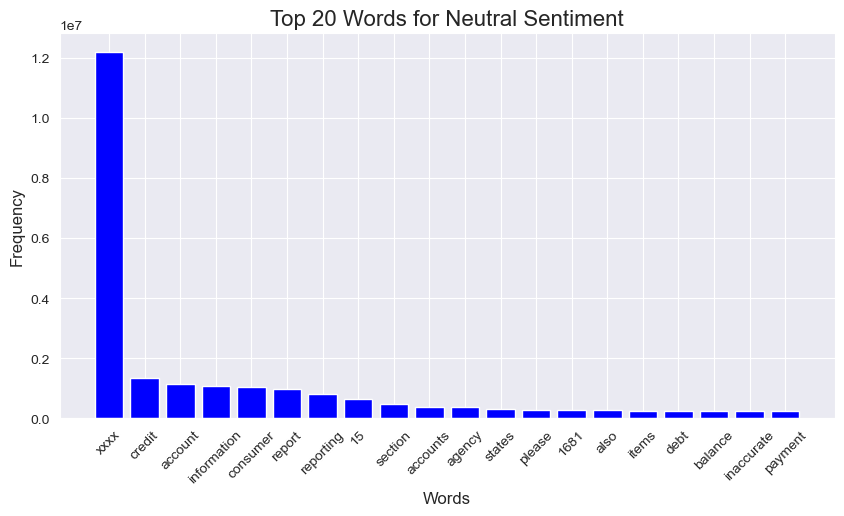

In [51]:
generate_visuals_neutral('Neutral')